# Анализ вакансий и определение грейда по резюме

## Данный ноутбук содержит две части:
1. Определение шкалы для определения грейда для резюме по спаршенным вакансиям из API HH
2. Построение синтетического датасета состоящий из резюме, где x = навыки, y = грейд(junior/middle/senior). Затем дообучение модели на этом датасете и анализ качеста генерации.

In [3]:
import torch
import pandas as pd
import numpy as np
import random
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from collections import defaultdict

In [4]:
SKILLS_TREE = {
    "Языки программирования": {
        "Низкоуровневые": ["c/с++", "c", "assembler", "rust", "go", "c++", "golang"],
        "Высокоуровневые": ["python", "java", "javascript", "c#", "php", "ruby", "typescript", "matlab"],
        "Функциональные": ["haskell", "scala", "erlang", "clojure", "f#"],
        "Скриптовые": ["python", "javascript", "perl", "lua", "bash"]
    },
    "Базы данных": {
        "SQL": ["sql", "postgresql", "mysql", "oracle", "sql server", "postgres"],
        "NoSQL": ["mongodb", "redis", "cassandra", "elasticsearch", "dynamodb"]
    },
    "Фреймворки": {
        "Веб": ["django", "flask", "spring", "laravel", "ruby on rails", "express"],
        "Мобильные": ["react native", "flutter", "xamarin"],
        "Тестирование": ["pytest", "junit", "selenium", "jest", "mocha"]
    },
    "DevOps": {
        "Контейнеризация": ["docker", "kubernetes", "docker-compose"],
        "CI/CD": ["jenkins", "gitlab ci", "github actions", "teamcity"],
        "Облака": ["aws", "azure", "google cloud", "gcp", "amazon web services"]
    },
    "Frontend": {
        "Основы": ["html", "css", "javascript", "html5", "css3"],
        "Фреймворки": ["react", "angular", "vue.js", "svelte"]
    },
    "Backend": {
        "Серверные языки": ["java", "c#", "python", "php", "ruby", "node.js"],
        "API": ["rest", "graphql", "grpc", "soap"]
    },
    "Машинное обучение": {
        "Основные библиотеки": ["tensorflow", "pytorch", "keras", "scikit-learn", "opencv"],
        "Обработка данных": ["pandas", "numpy", "spark", "dask", "pyspark"],
        "ML Ops": ["mlflow", "kubeflow", "airflow", "sagemaker"],
        "Компьютерное зрение": ["opencv", "yolo", "detectron", "image processing"],
        "NLP": ["nltk", "spacy", "transformers", "bert", "gpt"]
    },
    "Data Science": {
        "Анализ данных": ["pandas", "numpy", "matplotlib", "seaborn", "plotly"],
        "Визуализация": ["tableau", "power bi", "matplotlib", "seaborn"],
        "Big Data": ["hadoop", "spark", "hive", "kafka"]
    }
}

In [5]:
def get_vacancies_by_level(level_keyword, pages=20):
    all_vacancies = []
    for page in range(pages):
        response = requests.get("https://api.hh.ru/vacancies", params={
            "text": f"{level_keyword}",
            "professional_role": 96,
            "area": 1,
            "per_page": 100,
            "page": page
        })
        data = response.json()
        items = data.get("items", [])
        all_vacancies.extend(items)
    return all_vacancies


In [6]:
def analyze_vacancies(vacancies):
    analyzed = []
    for v in vacancies:
        try:
            detail = requests.get(v["url"]).json()
            skills = [s["name"].lower().strip() for s in detail.get("key_skills", [])]
            
            if skills:
                analyzed.append({
                    "skills_count": len(skills),
                    "skills": skills
                })
        except Exception as e:
            print(f"Error processing vacancy: {e}")
            continue
    return analyzed

In [7]:
def analyze_skills_by_tree(vacancies, skills_tree):
    skill_to_groups = defaultdict(list)
    
    # Строим обратное отображение: навык -> список его групп
    for main_category, subcategories in skills_tree.items():
        for subcategory, skills in subcategories.items():
            for skill in skills:
                skill_to_groups[skill].append((main_category, subcategory))
    
    results = []
    
    for vacancy in vacancies:
        vacancy_skills = vacancy.get("skills", [])
        level_stats = defaultdict(int)
        matched_main_categories = set()
        
        for skill in vacancy_skills:
            for main_cat, sub_cat in skill_to_groups.get(skill, []):
                matched_main_categories.add(main_cat)
                level_stats[main_cat] += 1
                level_stats[f"{main_cat}/{sub_cat}"] += 1
        
        results.append({
            "total_groups": len(matched_main_categories),
            "groups": list(matched_main_categories),
            "level_stats": dict(level_stats)
        })
    
    return results

In [8]:
def get_grade_statistics(pages_per_grade=5):
    result = {}
    
    for grade in ['junior', 'middle', 'senior']:
        try:
            vacancies = get_vacancies_by_level(f"{grade}", pages=pages_per_grade)
            analyzed_vacancies = analyze_vacancies(vacancies)
            
            if not analyzed_vacancies:
                print(f"Нет данных для анализа {grade}")
                result[grade] = {'mean_skills': 0.0, 'mean_main_categories': 0.0}
                continue
            
            analysis_results = analyze_skills_by_tree(analyzed_vacancies, SKILLS_TREE)
            
            mean_skills = np.mean([len(v['skills']) for v in analyzed_vacancies if v.get('skills')])
            
            main_categories = set(SKILLS_TREE.keys())
            category_counts = []
            
            for vacancy in analysis_results:
                count = sum(1 for cat in main_categories if vacancy['level_stats'].get(cat, 0) > 0)
                category_counts.append(count)
            
            mean_main_categories = np.mean(category_counts) if category_counts else 0.0
            
            result[grade] = {
                'mean_skills': round(float(mean_skills), 2),
                'mean_main_categories': round(float(mean_main_categories), 2)
            }
            
        except Exception as e:
            print(f"Ошибка при обработке {grade}: {str(e)}")
            result[grade] = {'mean_skills': 0.0, 'mean_main_categories': 0.0}
    
    return result


In [9]:
stats = get_grade_statistics(pages_per_grade=10)
print("Результаты анализа по грейдам:")
for grade, data in stats.items():
    print(f"{grade}:")
    print(f"  Среднее количество навыков: {data['mean_skills']}")
    print(f"  Среднее количество основных категорий: {data['mean_main_categories']}")
    print()

Результаты анализа по грейдам:
junior:
  Среднее количество навыков: 6.44
  Среднее количество основных категорий: 2.27

middle:
  Среднее количество навыков: 6.9
  Среднее количество основных категорий: 2.54

senior:
  Среднее количество навыков: 6.38
  Среднее количество основных категорий: 2.09



### Здесь кончается первая часть, получили некую шкалу распределения грейдов по навыкам.
### Но можно заметить, что уровень senior показывает среднее количество навыков меньше чем у других уровней и то же самое с охватом основных категорий из дерева навыков.
### Мое предположение таково, что данных либо слишком мало, либо они не качественные.
### Поэтому для следующей части а именно для генерации датасета я взял собственную шкалу, которая предполагает, что senior должен обладать большик количеством навыков и большим охватам по категорям навыков 

# Здесь начинается вторая часть: создание датасета, дообучение модели и оценка качества

In [10]:
tech_skills = {
    'Programming': ["c", "assembler", "rust", "go", "c++", "golang", "python", "java", "javascript", "c#", "php", "ruby", "typescript", "matlab", "haskell", "scala", "erlang", "clojure", "f#", "perl", "lua", "bash"],
    'Databases': ["sql", "postgresql", "mysql", "oracle", "sql server", "postgres", "mongodb", "redis", "cassandra", "elasticsearch", "dynamodb"],
    'DevOps': ["docker", "kubernetes", "docker-compose", "jenkins", "gitlab ci", "github actions", "teamcity", "aws", "azure", "google cloud", "gcp", "amazon web services"],
    'Frontend': ["html", "css", "javascript", "html5", "css3", "react", "angular", "vue.js", "svelte"],
    'Data': ["pandas", "numpy", "matplotlib", "seaborn", "plotly", "tableau", "power bi", "hadoop", "spark", "hive", "kafka"],
    'ML': ["tensorflow", "pytorch", "keras", "scikit-learn", "opencv", "mlflow", "kubeflow", "airflow", "sagemaker", "yolo", "detectron", "image processing", "nltk", "spacy", "transformers", "bert", "gpt"]
}

In [11]:
def generate_resumes_advanced(num_resumes=500):
    resumes = []
    grades = ['junior', 'middle', 'senior']
    skill_groups = list(tech_skills.keys())
    
    for _ in range(num_resumes):
        grade = random.choice(grades)
        current_skills = set()
        
        if grade == 'junior':
            num_groups = random.randint(1, 2)
            groups_to_use = random.sample(skill_groups, num_groups)
            total_skills_to_add = random.randint(2, 4)
        elif grade == 'middle':
            num_groups = random.randint(2, 4)
            groups_to_use = random.sample(skill_groups, num_groups)
            total_skills_to_add = random.randint(5, 8)
        else:
            num_groups = random.randint(4, 6)
            groups_to_use = random.sample(skill_groups, num_groups)
            total_skills_to_add = random.randint(8, 12)
            
        for _ in range(total_skills_to_add):
            group = random.choice(groups_to_use)
            skill = random.choice(tech_skills[group])
            current_skills.add(skill)
        
        skills_list = list(current_skills)
        random.shuffle(skills_list)
        skills_text = ", ".join(skills_list)
        resumes.append({'grade': grade, 'skills_text': skills_text})
    return pd.DataFrame(resumes)

df_resumes = generate_resumes_advanced(num_resumes=2000)

In [12]:
label2id = {"junior": 0, "middle": 1, "senior": 2}
id2label = {v: k for k, v in label2id.items()}
df_resumes['label'] = df_resumes['grade'].map(label2id)

train_df, val_df = train_test_split(df_resumes, test_size=0.2, stratify=df_resumes['label'], random_state=42)

In [18]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df["skills_text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
train_dataset = ResumeDataset(train_df, tokenizer)
val_dataset = ResumeDataset(val_df, tokenizer)

In [19]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import wandb
wandb.init(mode="offline")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
)

data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_35/1144587949.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.720100
100,0.418600
150,0.363400
200,0.316100
250,0.263100
300,0.256500


TrainOutput(global_step=300, training_loss=0.3896357313791911, metrics={'train_runtime': 111.2618, 'train_samples_per_second': 43.141, 'train_steps_per_second': 2.696, 'total_flos': 315736101273600.0, 'train_loss': 0.3896357313791911, 'epoch': 3.0})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Accuracy на валидации: 88.75%

Classification Report:
              precision    recall  f1-score   support

      junior       0.90      0.99      0.94       125
      middle       0.90      0.76      0.82       139
      senior       0.87      0.92      0.89       136

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.88       400



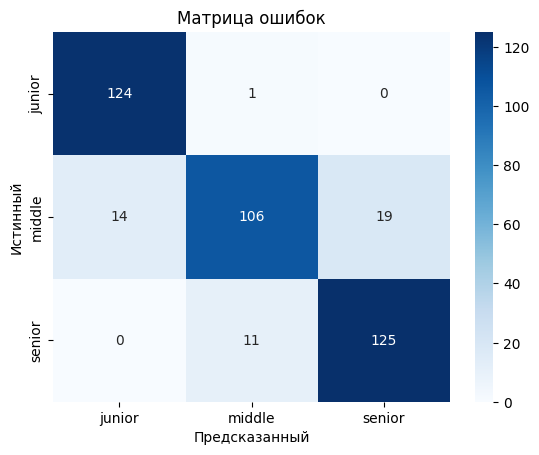

In [17]:
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy на валидации: {acc:.2%}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label2id.keys())))

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel("Предсказанный")
plt.ylabel("Истинный")
plt.title("Матрица ошибок")
plt.show()

## По результатам можно видеть, что модель после дообучения показывает очень хороший результат, а именно accuracy = 89%.
## Так же привел Confusion Matrix, чтобы можно было увидеть где модель ошибается